# FMO dynamics simulated with ZOFE master equation

Setup the Hamiltonian and dynamical model for FMO (see [arXiv:1307](http://arxiv.org/abs/1307.4807)):

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qspectra import *

In [2]:
electronic_fmo = np.array(np.mat("""
    12400 -87.7 5.5 -5.9 6.7 -13.7 -9.9;
    -87.7 12520 30.8 8.2 0.7 11.8 4.3;
    5.5 30.8 12200 -53.5 -2.2 -9.6 6.;
    -5.9 8.2 -53.5 12310 -70.7 -17. -63.3;
    6.7 0.7 -2.2 -70.7 12470 81.1 -1.3;
    -13.7 11.8 -9.6 -17. 81.1 12620 39.7;
    -9.9 4.3 6. -63.3 -1.3 39.7 12430
    """))

dipoles_fmo = np.array([d / np.linalg.norm(d) for d in
    np.array([[3.019, 3.442, 0.797, 3.213, 2.969, 0.547, 1.983],
              [2.284, -2.023, -3.871, 2.145, -2.642, 3.562, 2.837],
              [1.506, 0.431, 0.853, 1.112, -0.661, -1.851, 2.015]]).T])

# Bath parameters for pseudomode bath -- fit to the Drude spectral density for FMO for 77K of Ishizaki and Fleming
# (each PM is represented by a Lorentzian at frequency Omega, with width gamma, and of strength huang
#  in the bath correlation SPECTRUM, NOT spectral density)

Omega = [-500., -200., -90., 1., 21., 60., 80., 130., 200., 300., 400., 500., 600., 800., 1100., 1500.] # frequencies of PMs
huang = [-2.5133e-03, -7.5398e-03, -2.5133e-02, 5.0265e+01, 2.2619e+00, 4.5239e-02, 2.7646e-01,
          9.2991e-03, 2.2619e-02, 1.5080e-02, 3.0159e-03, 
          3.5186e-03, 2.8274e-04, 1.7593e-03, 4.3982e-04, 4.3982e-04] # Huang-Rhys factors of PMs (couplings to PMs)
gamma = [500., 100., 50., 50., 50., 50., 80., 40., 80., 150., 200., 200., 80., 250., 200., 300.] # dampings of the PMs

n_sites = len(electronic_fmo)
numb_pm = len(Omega)
on = np.ones(n_sites, complex)

Omega = np.array([Omega[pm]*on for pm in range(numb_pm)])
huang = np.array([huang[pm]*on for pm in range(numb_pm)])
gamma = np.array([gamma[pm]*on for pm in range(numb_pm)])


fmo_hamiltonian = ElectronicHamiltonian(electronic_fmo, 
                                        bath=PseudomodeBath(numb_pm, Omega, gamma, huang), 
                                        dipoles=dipoles_fmo)

## Excited state dynamics

Simulate dynamics in the 1-excitation subspace starting on site 1 for 1 ps:

In [3]:
%%time
dynamical_model = ZOFEModel(fmo_hamiltonian, hilbert_subspace='e', unit_convert=CM_FS)
t, rho = simulate_dynamics(dynamical_model, [1,0,0,0,0,0,0], 1000)

CPU times: user 7.59 s, sys: 397 ms, total: 7.99 s
Wall time: 16.5 s


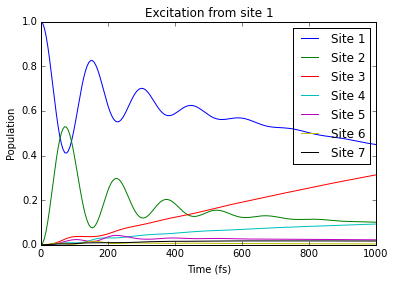

In [4]:
plt.title('Excitation from site 1')
plt.plot(t, np.einsum('tii->ti', rho.reshape(-1, 7, 7)).real)
plt.xlim(0, 1000)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.legend(['Site {}'.format(n) for n in xrange(1, 8)]);

## Gaussian pump pulse

Simulate dynamics for an x-polarized Gaussian pump pulse centered at 800nm with a 50fs FWHM:

In [5]:
%%time
pump = GaussianPulse(12500, 50, scale=1e-3, freq_convert=CM_FS)
dynamical_model = ZOFEModel(fmo_hamiltonian, hilbert_subspace='ge', unit_convert=CM_FS)
t, rho_oop_vec = simulate_pump(dynamical_model, pump, 'x', 1000)
rho = np.array([dynamical_model.state_vec_to_operators(k)[0] for k in rho_oop_vec])

CPU times: user 17.4 s, sys: 749 ms, total: 18.1 s
Wall time: 34.2 s


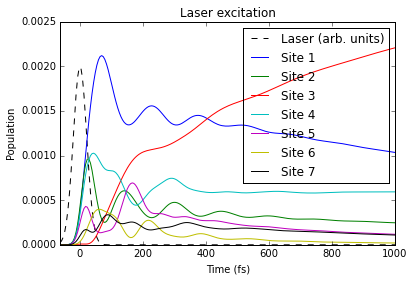

In [6]:
plt.title('Laser excitation')
plt.plot(t, 2 * pump(t, 12500).real, 'k--')
plt.plot(t, np.einsum('tii->ti', rho.reshape(-1, 8, 8)[:, 1:, 1:]).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(pump.t_init, 1000)
plt.legend(np.concatenate([['Laser (arb. units)'], ['Site {}'.format(n) for n in xrange(1, 8)]]));

## Absorption spectra

In [7]:
%%time
f, X = absorption_spectra(dynamical_model, 2000)

CPU times: user 16.6 s, sys: 732 ms, total: 17.3 s
Wall time: 31.8 s


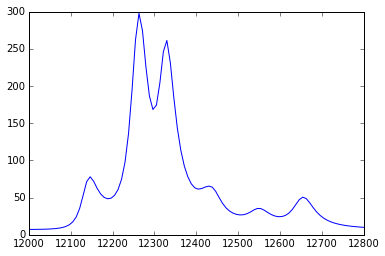

In [8]:
plt.plot(f, X)
plt.xlim(12000, 12800);